# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

315871939

314804568

## Please sign that you have read and understood the instructions: 

### *** YOUR RUNI EMAILS HERE ***

ariel.rabinovitch@post.runi.ac.il

erel.vanono@post.runi.ac.il



In [5]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

#### Overview

AdaBoost (Adaptive Boosting) is an ensemble learning algorithm that combines multiple weak learners to form a strong classifier. It works by iteratively training weak classifiers on weighted data and combining their outputs using a weighted vote.

We will implement the AdaBoost algorithm for binary classification using decision stumps (1-level decision trees) as base learners. The key idea is to adaptively adjust the weights of training samples based on the performance of the previous learners.

#### Algorithm Steps

Start with uniform weights over the training samples: $$w_i = \frac{1}{N} \quad \forall i \in \{1, \ldots, N\}$$

For each boosting round $t=1,...,T$:

* Train a weak learner $h_t$ using the weighted dataset.

* Compute the weighted training error: $$\epsilon_t = \frac{\sum_{i=1}^N w_i \cdot \mathbb{I}(h_t(x_i) \ne y_i)}{\sum_{i=1}^N w_i}$$

* Compute the model weight: $$\alpha_t = \frac{1}{2} \ln\left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$$

* Update sample weights: $$w_i \leftarrow w_i \cdot \exp\left(-\alpha_t \, y_i \, h_t(x_i)\right)$$

* Normalize weights so that they sum to 1.

The output of AdaBoost is: $$H(x) = \text{sign}\left( \sum_{t=1}^T \alpha_t \, h_t(x) \right)$$


#### Hyperparameters

**T (Number of rounds):** Number of weak learners to train. A higher value generally improves performance but may lead to overfitting.

**Base learner:** We'll use decision stumps. Optionally, we can try deeper trees later for comparison.

####  Optimization and Efficiency

* Use vectorized operations for weight updates and error calculation to improve performance.

* Use sklearn.tree.DecisionTreeClassifier(max_depth=1) for the weak learner.

* To reduce runtime, optionally allow subsampling of data (if needed).

* Monitor performance during boosting to implement early stopping if desired.

#### Use Cases and Limitations

**Good for:** Binary classification tasks with structured/tabular data; handling non-linear decision boundaries.

**Limitations:**

* Sensitive to noisy data and outliers.

* Less interpretable than simpler models.

* Not suitable for multi-class without modification (e.g., AdaBoost.M2 or SAMME).


# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [2]:
from sklearn.tree import DecisionTreeClassifier

class AdaBoostCustom:
    def __init__(self, T):
        self.T = T
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        """
        Fit the AdaBoost model using T rounds and decision stumps as weak learners.
        :param X: Training features, shape (n_samples, n_features)
        :param y: Labels in {-1, 1}, shape (n_samples,)
        """
        n_samples = X.shape[0]
        # Initialize sample weights uniformly
        w = np.ones(n_samples) / n_samples

        for t in range(self.T):
            # Train a decision stump
            stump = DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=w)
            pred = stump.predict(X)

            # Compute weighted error
            err = np.sum(w * (pred != y)) / np.sum(w)

            # Avoid division by zero or perfect prediction
            if err == 0:
                alpha = 1e10
            elif err >= 0.5:
                continue  # skip this round if it's worse than random
            else:
                alpha = 0.5 * np.log((1 - err) / err)

            # Update weights
            w = w * np.exp(-alpha * y * pred)
            w /= np.sum(w)  # Normalize

            # Save model and alpha
            self.models.append(stump)
            self.alphas.append(alpha)

    def predict(self, X):
        """
        Predict using the trained AdaBoost model.
        :param X: Test features, shape (n_samples, n_features)
        :return: Predicted labels in {-1, 1}
        """
        if not self.models:
            raise ValueError("Model not trained. Call `fit` first.")

        final_pred = np.zeros(X.shape[0])
        for alpha, model in zip(self.alphas, self.models):
            final_pred += alpha * model.predict(X)

        return np.sign(final_pred)


# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We use a 2D synthetic binary classification dataset generated with `sklearn.datasets.make_classification`:

- **Low-dimensional (2 features)** — allows easy visualization.
- **5% label noise** — introduces imperfect data to test AdaBoost’s robustness.
- **Some class overlap** — makes the task non-trivial and ideal for weak learners to iteratively improve.
- Labels are mapped from {0,1} to {-1,1} as required for the AdaBoost update formula.

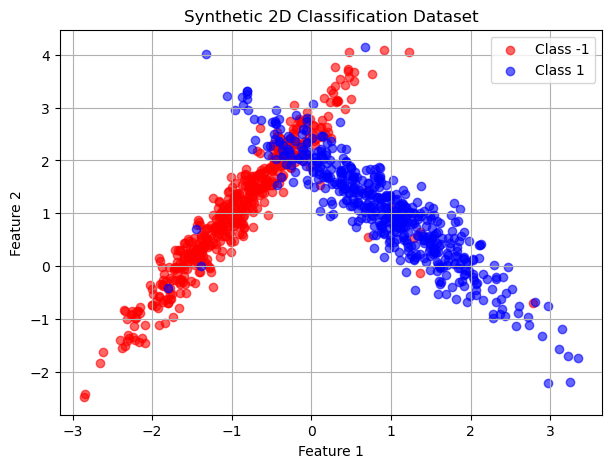

In [3]:
# Generate 2D synthetic classification data with slight label noise
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, flip_y=0.05, class_sep=1.0, random_state=42)

# Transform labels from {0,1} to {-1,1} for AdaBoost compatibility
y = 2 * y - 1

# Plot the generated data
plt.figure(figsize=(7, 5))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1', alpha=0.6)
plt.title("Synthetic 2D Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

### AdaBoost Demonstration

We tested both our custom AdaBoost implementation and `sklearn`'s on the same dataset:

- **Accuracy**: Both models perform similarly, indicating our implementation is functionally correct.
- **Confusion Matrices**: Show similar prediction patterns, reinforcing that our custom model is effective.
- **Differences**:
  - Our model explicitly implements sample reweighting and weak learner weighting using AdaBoost theory.
  - `sklearn` includes additional features like learning rate control, early stopping, and internal optimizations.
  - Our implementation uses label encoding \{-1, 1\}, whereas `sklearn` uses \{0, 1\}.

This side-by-side comparison validates our approach and shows how AdaBoost reduces error by focusing on misclassified points over time.

c:\Users\Ariel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Custom AdaBoost Accuracy: 0.88
Sklearn AdaBoost Accuracy: 0.89


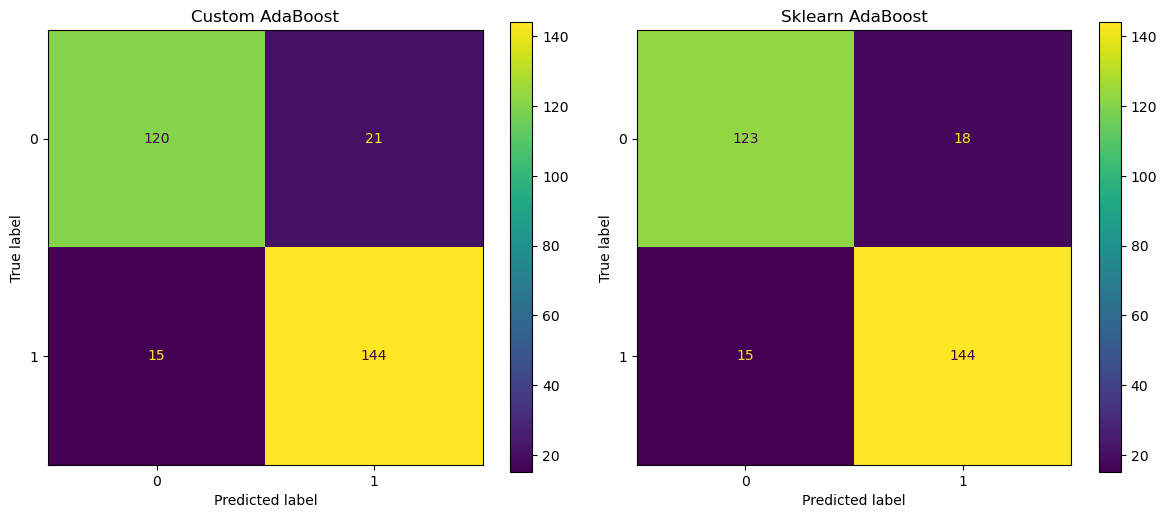

In [6]:
custom_model = AdaBoostCustom(T=10)
sklearn_model = AdaBoostClassifier(n_estimators=10, random_state=42)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train custom AdaBoost implementation
custom_model.fit(X_train, y_train)
custom_preds = custom_model.predict(X_test)

# Train sklearn AdaBoost (with updated parameter name)
sklearn_model.fit(X_train, (y_train + 1) // 2)
sklearn_preds = sklearn_model.predict(X_test)

# Accuracy scores
print("Custom AdaBoost Accuracy:", accuracy_score((y_test + 1) // 2, (custom_preds + 1) // 2))
print("Sklearn AdaBoost Accuracy:", accuracy_score((y_test + 1) // 2, sklearn_preds))

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions((y_test + 1) // 2, (custom_preds + 1) // 2, ax=ax[0])
ax[0].set_title("Custom AdaBoost")

ConfusionMatrixDisplay.from_predictions((y_test + 1) // 2, sklearn_preds, ax=ax[1])
ax[1].set_title("Sklearn AdaBoost")

plt.tight_layout()
plt.show()

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [ ]:
# Generate additional data sets

# Split data sets

In [ ]:
# Visualize data

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [ ]:
# Set up models 

In [ ]:
# Test and visualize

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 